In [1]:
#!pipenv run pip freeze > requirements.txt

### Using Spark SQL in Spark Applications
#### Using Spark SQL in Spark Applications


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder.appName("SparkSQLExample").enableHiveSupport().getOrCreate()

In [87]:
csv_file = "data/departuredelays.csv"

file_schema = "date STRING, delay INT, distance INT,origin STRING, destination STRING"

In [88]:
#By setting inferSchema=true, 
#Spark will automatically go through the csv file
#and infer the schema of each column.

df = (
    spark.read.format("csv")
    .schema(file_schema)
    .option("inferSchema","true")
    .option("header","true")
    .load(csv_file)
    
)

df.createOrReplaceTempView("us_delay_flights_tbl")

In [89]:
#If you want to specify a schema, you can use a DDL-formatted
#string. For example:

# In Python
'''
schema = "`date` STRING, `delay` INT, `distance` INT,
`origin` STRING, `destination` STRING"

'''

'\nschema = "`date` STRING, `delay` INT, `distance` INT,\n`origin` STRING, `destination` STRING"\n\n'

In [90]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)



In [91]:
# With Query
spark.sql('''
SELECT distance, origin, destination FROM us_delay_flights_tbl
WHERE distance > 1000 ORDER BY distance DESC
''').show(10)

# With DateFrame API
(
    df.select('distance', 'origin', 'destination')
    .where('distance > 1000')
    .orderBy('distance', ascending=False)
).show(10)

+--------+------+-----------+
|distance|origin|destination|
+--------+------+-----------+
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
+--------+------+-----------+
only showing top 10 rows

+--------+------+-----------+
|distance|origin|destination|
+--------+------+-----------+
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
|    4330|   HNL|        JFK|
+--------+------+-----------+
only showing top 10 rows



In [92]:
# With Query

spark.sql('''

SELECT date, delay, origin, destination FROM us_delay_flights_tbl
WHERE delay > 120 AND origin = 'SFO' and destination = 'ORD'
ORDER BY delay DESC
''').show(10)

# With API

cond1 = col("delay") > 120
cond2 = col("origin") == 'SFO'
cond3 = col("destination") == 'ORD'

(
    df.select("date", "delay", "origin", "destination")
    .where(cond1 & cond2 & cond3)
    .orderBy("delay", ascending=False)
).show(10)


+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|02190925| 1638|   SFO|        ORD|
|01031755|  396|   SFO|        ORD|
|01022330|  326|   SFO|        ORD|
|01051205|  320|   SFO|        ORD|
|01190925|  297|   SFO|        ORD|
|02171115|  296|   SFO|        ORD|
|01071040|  279|   SFO|        ORD|
|01051550|  274|   SFO|        ORD|
|03120730|  266|   SFO|        ORD|
|01261104|  258|   SFO|        ORD|
+--------+-----+------+-----------+
only showing top 10 rows

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|02190925| 1638|   SFO|        ORD|
|01031755|  396|   SFO|        ORD|
|01022330|  326|   SFO|        ORD|
|01051205|  320|   SFO|        ORD|
|01190925|  297|   SFO|        ORD|
|02171115|  296|   SFO|        ORD|
|01071040|  279|   SFO|        ORD|
|01051550|  274|   SFO|        ORD|
|03120730|  266|   SFO|        ORD|
|01261104|  258|   SFO|        ORD|
+-

In [93]:
#UDF For convert date to readable date
def to_date_format_udf(d_str):
    l = [char for char in d_str]
    return "".join(l[0:2]) + "/" +  "".join(l[2:4]) + " " + " " +"".join(l[4:6]) + ":" + "".join(l[6:])

In [94]:
to_date_format_udf("02190925")

'02/19  09:25'

In [95]:
#Register the UDF
spark.udf.register("to_date_format_udf", to_date_format_udf,StringType())

<function __main__.to_date_format_udf(d_str)>

In [96]:
(
    df
    .selectExpr("to_date_format_udf(date) as data_format")
    .show(10, truncate=False)
)

+------------+
|data_format |
+------------+
|01/01  12:45|
|01/02  06:00|
|01/02  12:45|
|01/02  06:05|
|01/03  12:45|
|01/03  06:05|
|01/04  12:43|
|01/04  06:05|
|01/05  12:45|
|01/05  06:05|
+------------+
only showing top 10 rows



In [97]:
spark.sql('''
SELECT *, date, to_date_format_udf(date) as date_fm FROM
us_delay_flights_tbl
''').show(10)

+--------+-----+--------+------+-----------+--------+------------+
|    date|delay|distance|origin|destination|    date|     date_fm|
+--------+-----+--------+------+-----------+--------+------------+
|01011245|    6|     602|   ABE|        ATL|01011245|01/01  12:45|
|01020600|   -8|     369|   ABE|        DTW|01020600|01/02  06:00|
|01021245|   -2|     602|   ABE|        ATL|01021245|01/02  12:45|
|01020605|   -4|     602|   ABE|        ATL|01020605|01/02  06:05|
|01031245|   -4|     602|   ABE|        ATL|01031245|01/03  12:45|
|01030605|    0|     602|   ABE|        ATL|01030605|01/03  06:05|
|01041243|   10|     602|   ABE|        ATL|01041243|01/04  12:43|
|01040605|   28|     602|   ABE|        ATL|01040605|01/04  06:05|
|01051245|   88|     602|   ABE|        ATL|01051245|01/05  12:45|
|01050605|    9|     602|   ABE|        ATL|01050605|01/05  06:05|
+--------+-----+--------+------+-----------+--------+------------+
only showing top 10 rows



In [98]:
spark.sql('''

SELECT to_date_format_udf(date), delay, origin, destination FROM us_delay_flights_tbl
WHERE delay > 120 AND origin = 'SFO' and destination = 'ORD'
ORDER BY delay DESC

''').show(10)

+------------------------+-----+------+-----------+
|to_date_format_udf(date)|delay|origin|destination|
+------------------------+-----+------+-----------+
|            02/19  09:25| 1638|   SFO|        ORD|
|            01/03  17:55|  396|   SFO|        ORD|
|            01/02  23:30|  326|   SFO|        ORD|
|            01/05  12:05|  320|   SFO|        ORD|
|            01/19  09:25|  297|   SFO|        ORD|
|            02/17  11:15|  296|   SFO|        ORD|
|            01/07  10:40|  279|   SFO|        ORD|
|            01/05  15:50|  274|   SFO|        ORD|
|            03/12  07:30|  266|   SFO|        ORD|
|            01/26  11:04|  258|   SFO|        ORD|
+------------------------+-----+------+-----------+
only showing top 10 rows



In [99]:
# With Query
spark.sql("""SELECT delay, origin, destination,
CASE
WHEN delay > 360 THEN 'Very Long Delays'
WHEN delay > 120 AND delay < 360 THEN 'Long Delays'
WHEN delay > 60 AND delay < 120 THEN 'Short Delays'
WHEN delay > 0 and delay < 60 THEN 'Tolerable Delays'
WHEN delay = 0 THEN 'No Delays'
ELSE 'Early'
END AS Flight_Delays
FROM us_delay_flights_tbl
ORDER BY origin, delay DESC""").show(10)

# With API


vld = col("delay") > 360
ld = (col("delay") > 120) & (col("delay") < 360)
sh = (col("delay") > 60) & (col("delay") < 120)
td = (col("delay") > 0) & (col("delay") < 60)
nd = col("delay") == 0

(
df.select("delay","origin", "destination"
          ,when(vld,'Very Long Delays')
          .when(nd,'No Delays')
          .when(ld, 'Long Delays')
          .when(sh,'Short Delays')
          .when(td, 'Tolerable Delays')          
          .when(nd,'No Delays')
          .otherwise("Early")
          .alias("Flight_Delays")
         )
    #.withColumnRenamed("origin","no")
    .orderBy(["origin","delay"],ascending=[1,0])
).show(10)


+-----+------+-----------+-------------+
|delay|origin|destination|Flight_Delays|
+-----+------+-----------+-------------+
|  333|   ABE|        ATL|  Long Delays|
|  305|   ABE|        ATL|  Long Delays|
|  275|   ABE|        ATL|  Long Delays|
|  257|   ABE|        ATL|  Long Delays|
|  247|   ABE|        ATL|  Long Delays|
|  247|   ABE|        DTW|  Long Delays|
|  219|   ABE|        ORD|  Long Delays|
|  211|   ABE|        ATL|  Long Delays|
|  197|   ABE|        DTW|  Long Delays|
|  192|   ABE|        ORD|  Long Delays|
+-----+------+-----------+-------------+
only showing top 10 rows

+-----+------+-----------+-------------+
|delay|origin|destination|Flight_Delays|
+-----+------+-----------+-------------+
|  333|   ABE|        ATL|  Long Delays|
|  305|   ABE|        ATL|  Long Delays|
|  275|   ABE|        ATL|  Long Delays|
|  257|   ABE|        ATL|  Long Delays|
|  247|   ABE|        ATL|  Long Delays|
|  247|   ABE|        DTW|  Long Delays|
|  219|   ABE|        ORD|  Lon

In [100]:
# 1 asc, 0 desc
(
    df.selectExpr("delay", "origin", "destination","""
CASE
WHEN delay > 360 THEN 'Very Long Delays'
WHEN delay > 120 AND delay < 360 THEN 'Long Delays'
WHEN delay > 60 AND delay < 120 THEN 'Short Delays'
WHEN delay > 0 and delay < 60 THEN 'Tolerable Delays'
WHEN delay = 0 THEN 'No Delays'
ELSE 'Early'
END AS Flight_Delays""")
    .orderBy(["origin","delay"],ascending=[1,0])
    .show(10)
)

+-----+------+-----------+-------------+
|delay|origin|destination|Flight_Delays|
+-----+------+-----------+-------------+
|  333|   ABE|        ATL|  Long Delays|
|  305|   ABE|        ATL|  Long Delays|
|  275|   ABE|        ATL|  Long Delays|
|  257|   ABE|        ATL|  Long Delays|
|  247|   ABE|        ATL|  Long Delays|
|  247|   ABE|        DTW|  Long Delays|
|  219|   ABE|        ORD|  Long Delays|
|  211|   ABE|        ATL|  Long Delays|
|  197|   ABE|        DTW|  Long Delays|
|  192|   ABE|        ORD|  Long Delays|
+-----+------+-----------+-------------+
only showing top 10 rows



In [101]:
# pg 89

### SQL Tables and Views
#### Managed Versus UnmanagedTables
##### 1. Creating Managed SQL Databases and Tables

In [129]:
spark.catalog.listDatabases()

[Database(name='default', description='Default Hive database', locationUri='file:/home/usman/Documents/learningSpark/Chap4/spark-warehouse'),
 Database(name='learn_spark_db', description='', locationUri='file:/home/usman/Documents/learningSpark/Chap4/spark-warehouse/learn_spark_db.db')]

In [149]:
spark.catalog.listTables('learn_spark_db')
#spark.sql("DROP TABLE us_origin_airport_jfk_tmp_view")

[Table(name='managed_us_delay_flights_tbl', database='learn_spark_db', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='us_delay_flights_tbl', database='learn_spark_db', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='us_origin_airport_jfk_tmp_view', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [124]:
spark.sql("CREATE DATABASE learn_spark_db")

DataFrame[]

In [125]:
#spark.sql("DROP DATABASE learn_spark_db")

In [150]:
spark.sql("USE learn_spark_db")

DataFrame[]

In [161]:
#spark.sql("CREATE TABLE managed_us_delay_flights_tbl (date STRING, delay INT, distance INT, origin STRING, destination STRING)")


    #You can do the same thing using the DataFrame API like this:
# In Python
# Path to our US flight delays CSV file
    #csv_file = "/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
# Schema as defined in the preceding example
schema="date STRING, delay INT, distance INT, origin STRING, destination STRING"
flights_df = spark.read.csv(csv_file, schema=schema)
flights_df.write.saveAsTable("managed_us_delay_flights_tbl")



In [157]:
#df.write.saveAsTable("managed_us_delay_flights_tbl")

#spark.sql("CREATE TABLE managed_us_delay_flights_tbl (date STRING, delay INT,distance INT, origin STRING, destination STRING)")

DataFrame[]

In [158]:
#spark.sql("DROP TABLE managed_us_delay_flights_tbl")

DataFrame[]

In [133]:
#page 90

##### 2. Creating an unmanaged table

In [134]:
#page 91

In [173]:
#with Spark SQL
spark.sql("""
CREATE TABLE us_delay_flights_tbl (date STRING, delay INT, distance INT,
origin STRING, destination STRING)
USING csv OPTIONS (PATH '/data/departuredelays.csv')
""")

AnalysisException: Table learn_spark_db.us_delay_flights_tbl already exists.

In [137]:
# Will create folder and write unmanaged table
# Spark API
'''
(
    df.write
    .option("path", "data/unmanaged/us_flights_delay")
    .saveAsTable("us_delay_flights_tbl")
)
'''

'\n(\n    df.write\n    .option("path", "data/unmanaged/us_flights_delay")\n    .saveAsTable("us_delay_flights_tbl")\n)\n'

In [61]:
#spark.sql("DROP TABLE us_delay_flights_tbl")

###### 3. Creating Views

In [170]:
#with Spark SQL
spark.sql(

    #Origin = SFO
    
"""
CREATE OR REPLACE GLOBAL TEMP VIEW us_origin_airport_SFO_global_tmp_view AS
SELECT date, delay, origin, destination from us_delay_flights_tbl WHERE
origin = 'SFO';
"""
)

spark.sql(
    
    #Origin JFK
    
"""
CREATE OR REPLACE TEMP VIEW us_origin_airport_JFK_tmp_view AS
SELECT date, delay, origin, destination from us_delay_flights_tbl WHERE
origin = 'JFK'
"""
)

DataFrame[]

In [143]:
#Select from view
#spark.sql("SELECT date FROM us_origin_airport_SFO_global_tmp_view").show(10)


In [189]:
df_sfo = spark.sql("SELECT date, delay, origin, destination FROM managed_us_delay_flights_tbl WHERE origin = 'SFO'")
df_jfk = spark.sql("SELECT date, delay, origin, destination FROM managed_us_delay_flights_tbl WHERE origin = 'JFK'")
# Create a temporary and global temporary view
df_sfo.createOrReplaceGlobalTempView("us_origin_airport_SFO_global_tmp_view")
df_jfk.createOrReplaceTempView("us_origin_airport_JFK_tmp_view")

In [191]:
df_jfk.show(10)

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|02010900|   -1|   JFK|        LAX|
|02011200|   -5|   JFK|        LAX|
|02011030|   -6|   JFK|        LAX|
|02011900|   -1|   JFK|        LAX|
|02011700|   -3|   JFK|        LAS|
|02010800|   -4|   JFK|        SFO|
|02011540|    0|   JFK|        DFW|
|02011705|   30|   JFK|        SAN|
|02010800|   26|   JFK|        BOS|
|02011530|   -2|   JFK|        SFO|
+--------+-----+------+-----------+
only showing top 10 rows



In [174]:
spark.catalog.listTables("learn_spark_db")

[Table(name='managed_us_delay_flights_tbl', database='learn_spark_db', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='us_delay_flights_tbl', database='learn_spark_db', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='us_origin_airport_jfk_tmp_view', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [166]:
#spark.sql("DROP TABLE us_origin_airport_jfk_tmp_view")

In [176]:
spark.sql("SELECT * FROM managed_us_delay_flights_tbl").show(10)

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01010630|  -10|     928|   RSW|        EWR|
|01021029|   87|     974|   RSW|        ORD|
|01021346|    0|     928|   RSW|        EWR|
|01021044|   18|     928|   RSW|        EWR|
|01021730|   29|     748|   RSW|        IAH|
|01020535|  605|     974|   RSW|        ORD|
|01021820|   71|     974|   RSW|        ORD|
|01021743|    0|     928|   RSW|        EWR|
|01022017|    0|     928|   RSW|        EWR|
|01020600|   -2|     748|   RSW|        IAH|
+--------+-----+--------+------+-----------+
only showing top 10 rows



In [192]:
spark.read.table("us_origin_airport_JFK_tmp_view").show(10)

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|02010900|   -1|   JFK|        LAX|
|02011200|   -5|   JFK|        LAX|
|02011030|   -6|   JFK|        LAX|
|02011900|   -1|   JFK|        LAX|
|02011700|   -3|   JFK|        LAS|
|02010800|   -4|   JFK|        SFO|
|02011540|    0|   JFK|        DFW|
|02011705|   30|   JFK|        SAN|
|02010800|   26|   JFK|        BOS|
|02011530|   -2|   JFK|        SFO|
+--------+-----+------+-----------+
only showing top 10 rows



In [193]:
spark.sql("SELECT * FROM us_origin_airport_JFK_tmp_view").show(10)

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|02010900|   -1|   JFK|        LAX|
|02011200|   -5|   JFK|        LAX|
|02011030|   -6|   JFK|        LAX|
|02011900|   -1|   JFK|        LAX|
|02011700|   -3|   JFK|        LAS|
|02010800|   -4|   JFK|        SFO|
|02011540|    0|   JFK|        DFW|
|02011705|   30|   JFK|        SAN|
|02010800|   26|   JFK|        BOS|
|02011530|   -2|   JFK|        SFO|
+--------+-----+------+-----------+
only showing top 10 rows



In [198]:
spark.catalog.dropGlobalTempView("us_origin_airport_SFO_global_tmp_view")
spark.catalog.dropTempView("us_origin_airport_JFK_tmp_view")

### Data Sources for DataFrames and SQL Tables
#### 1. DataFrameReader

###### Spark SQL provides an interface to a variety of data sources
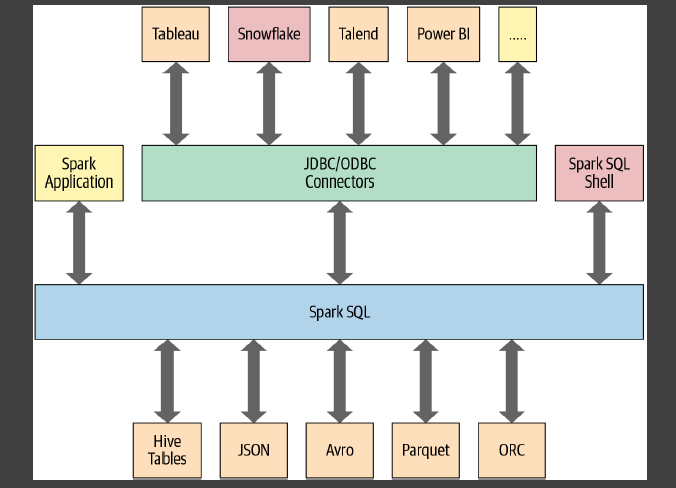

###### Arguments to each of the public methods to DataFrameReader take different values.
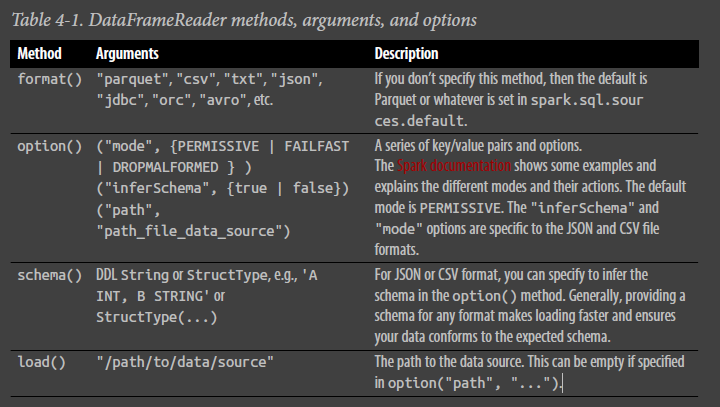

#### 2. DataFrameWriter
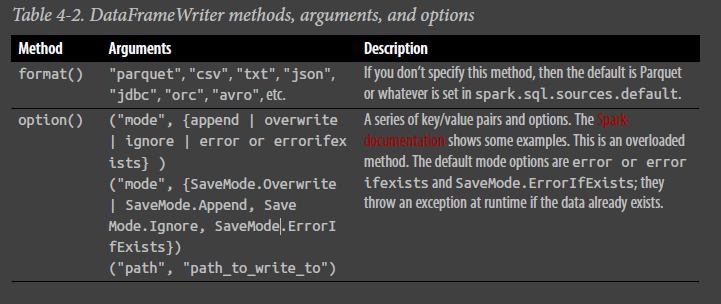
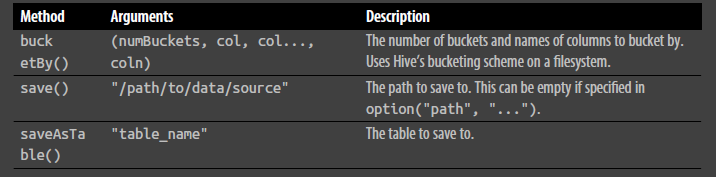

In [223]:
#path sould be defined in single line (based on observation)
file = """../databricks-datasets/learning-spark-v2/flights/summary-data/parquet/2010-summary.parquet/"""

In [224]:
df = spark.read.format("parquet").load(file)

###### Reading Parquet files into a Spark SQL table

In [225]:
#pg 98

In [226]:
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW us_delay_flightss_tbl
USING parquet
OPTIONS (
path "{}"
)
""".format(file))

DataFrame[]

In [227]:
spark.sql("SELECT * FROM us_delay_flightss_tbl").show()

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|       United States|            Romania|    1|
|       United States|            Ireland|  264|
|       United States|              India|   69|
|               Egypt|      United States|   24|
|   Equatorial Guinea|      United States|    1|
|       United States|          Singapore|   25|
|       United States|            Grenada|   54|
|          Costa Rica|      United States|  477|
|             Senegal|      United States|   29|
|       United States|   Marshall Islands|   44|
|              Guyana|      United States|   17|
|       United States|       Sint Maarten|   53|
|               Malta|      United States|    1|
|             Bolivia|      United States|   46|
|            Anguilla|      United States|   21|
|Turks and Caicos ...|      United States|  136|
|       United States|        Afghanistan|    2|
|Saint Vincent and..

###### Writing DataFrames to Parquet files

In [229]:
(df.write.format("parquet")
.mode("overwrite")
.option("compression", "snappy")
.save("../temp/data/parquet/df_parquet")
)